# SET UP ENVIROMENT

In [1]:
pip install cassandra-driver pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 18.5 MB/s eta 0:00:00


In [2]:
import cassandra
print(cassandra.__version__)


3.29.2


In [3]:
import os

# Create a directory named "bigdata_project"
os.mkdir("Bigdata_project")


In [4]:
import os

# Change to the "bigdata_project" directory
os.chdir("Bigdata_project")

# Verify the current working directory
print("Current Directory:", os.getcwd())

Current Directory: /content/Bigdata_project


# Connecting to cassendra


In [ ]:
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import json


cloud_config = {
    'secure_connect_bundle': '/content/Bigdata_project/secure-connect-sneha.zip'
}

with open("/content/Bigdata_project/Sneha-token.json") as f:
    secrets = json.load(f)


CLIENT_ID = secrets["clientId"]
CLIENT_SECRET = secrets["secret"]

auth_provider = PlainTextAuthProvider(CLIENT_ID, CLIENT_SECRET)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
session = cluster.connect()

row = session.execute("select release_version from system.local").one()
if row:
  print(row[0])
else:
  print("An error occurred.")

4.0.0.6816


# bronze table

In [ ]:
import pandas as pd
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import json
from uuid import uuid4

# Load secrets for authentication
with open("/content/Bigdata_project/Sneha-token.json") as f:
    secrets = json.load(f)

CLIENT_ID = secrets["clientId"]
CLIENT_SECRET = secrets["secret"]

# Connect to Cassandra cluster
cloud_config = {
    'secure_connect_bundle': '/content/Bigdata_project/secure-connect-sneha.zip'
}
auth_provider = PlainTextAuthProvider(CLIENT_ID, CLIENT_SECRET)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider, protocol_version=4)
session = cluster.connect()

# Set the keyspace
session.set_keyspace("sneha")

# Define table creation query
table_name = "drivers_data"
create_table_query = f"""
CREATE TABLE IF NOT EXISTS {table_name} (
    id UUID PRIMARY KEY,
    report_number TEXT,
    local_case_number TEXT,
    agency_name TEXT,
    acrs_report_type TEXT,
    crash_date_time TEXT,
    route_type TEXT,
    road_name TEXT,
    cross_street_name TEXT,
    off_road_description TEXT,
    municipality TEXT,
    related_non_motorist TEXT,
    collision_type TEXT,
    weather TEXT,
    surface_condition TEXT,
    light TEXT,
    traffic_control TEXT,
    driver_substance_abuse TEXT,
    non_motorist_substance_abuse TEXT,
    person_id TEXT,
    driver_at_fault TEXT,
    injury_severity TEXT,
    circumstance TEXT,
    driver_distracted_by TEXT,
    drivers_license_state TEXT,
    vehicle_id TEXT,
    vehicle_damage_extent TEXT,
    vehicle_first_impact_location TEXT,
    vehicle_body_type TEXT,
    vehicle_movement TEXT,
    vehicle_going_dir TEXT,
    speed_limit TEXT,
    driverless_vehicle TEXT,
    parked_vehicle TEXT,
    vehicle_year TEXT,
    vehicle_make TEXT,
    vehicle_model TEXT,
    latitude DOUBLE,
    longitude DOUBLE,
    location TEXT
);
"""
session.execute(create_table_query)
print(f"Table {table_name} created successfully!")

# Define INSERT query with positional placeholders
insert_query = f"""
INSERT INTO {table_name} (
    id, report_number, local_case_number, agency_name, acrs_report_type, crash_date_time,
    route_type, road_name, cross_street_name, off_road_description, municipality,
    related_non_motorist, collision_type, weather, surface_condition, light,
    traffic_control, driver_substance_abuse, non_motorist_substance_abuse, person_id,
    driver_at_fault, injury_severity, circumstance, driver_distracted_by,
    drivers_license_state, vehicle_id, vehicle_damage_extent,
    vehicle_first_impact_location, vehicle_body_type, vehicle_movement,
    vehicle_going_dir, speed_limit, driverless_vehicle, parked_vehicle,
    vehicle_year, vehicle_make, vehicle_model, latitude, longitude, location
) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
"""

# Load data from CSV
csv_file_path = "/content/Bigdata_project/Crash_Reporting_-_Drivers_Data.csv"
data = pd.read_csv(csv_file_path, low_memory=False)

# Replace NaN values with None for compatibility with Cassandra
data = data.where(pd.notnull(data), None)

# Ensure all numeric fields are converted to strings for compatibility
fields_to_convert = ["Speed Limit", "Vehicle Year"]
for field in fields_to_convert:
    data[field] = data[field].apply(lambda x: str(int(x)) if pd.notnull(x) else None)

# Insert all rows from the CSV file into the Cassandra table
try:
    for index, row in data.iterrows():
        values = (
            uuid4(),  # Generate a unique ID for each row
            row.get("Report Number"),
            row.get("Local Case Number"),
            row.get("Agency Name"),
            row.get("ACRS Report Type"),
            row.get("Crash Date/Time"),
            row.get("Route Type"),
            row.get("Road Name"),
            row.get("Cross-Street Name"),
            row.get("Off-Road Description"),
            row.get("Municipality"),
            row.get("Related Non-Motorist"),
            row.get("Collision Type"),
            row.get("Weather"),
            row.get("Surface Condition"),
            row.get("Light"),
            row.get("Traffic Control"),
            row.get("Driver Substance Abuse"),
            row.get("Non-Motorist Substance Abuse"),
            row.get("Person ID"),
            row.get("Driver At Fault"),
            row.get("Injury Severity"),
            row.get("Circumstance"),
            row.get("Driver Distracted By"),
            row.get("Drivers License State"),
            row.get("Vehicle ID"),
            row.get("Vehicle Damage Extent"),
            row.get("Vehicle First Impact Location"),
            row.get("Vehicle Body Type"),
            row.get("Vehicle Movement"),
            row.get("Vehicle Going Dir"),
            row.get("Speed Limit"),
            row.get("Driverless Vehicle"),
            row.get("Parked Vehicle"),
            row.get("Vehicle Year"),
            row.get("Vehicle Make"),
            row.get("Vehicle Model"),
            row.get("Latitude"),
            row.get("Longitude"),
            row.get("Location")
        )
        session.execute(insert_query, values)
    print("All rows inserted successfully!")
except Exception as e:
    print(f"Error inserting rows: {e}")

# Fetch all data from the table
fetch_query = f"SELECT * FROM {table_name}"
try:
    rows = session.execute(fetch_query)
    print("Fetched data from the table:")
    for row in rows:
        print(row)
except Exception as e:
    print(f"Error fetching data: {e}")


Streaming output truncated to the last 5000 lines.
Row(id=UUID('26c7e400-4b0a-46db-8033-93856966e097'), acrs_report_type='Property Damage Crash', agency_name='Montgomery County Police', circumstance='N/A, WET', collision_type='STRAIGHT MOVEMENT ANGLE', crash_date_time='09/05/2021 09:53:00 PM', cross_street_name='MERRIMAC DR', driver_at_fault='No', driver_distracted_by='NOT DISTRACTED', driver_substance_abuse='NONE DETECTED', driverless_vehicle='No', drivers_license_state='MD', injury_severity='NO APPARENT INJURY', latitude=38.994125, light='DARK LIGHTS ON', local_case_number='210034901', location='(38.994125, -76.99099333)', longitude=-76.99099333, municipality=None, non_motorist_substance_abuse=None, off_road_description=None, parked_vehicle='No', person_id='0467FBC0-AA71-4089-ADA0-45691C34CE06', related_non_motorist=None, report_number='MCP2919008F', road_name='UNIVERSITY BLVD E', route_type='Maryland (State)', speed_limit='35', surface_condition='WET', traffic_control=None, vehicle_

# Silver table

In [ ]:
import pandas as pd
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
import json
from uuid import uuid4

# Load secrets for authentication
with open("/content/Bigdata_project/Sneha-token.json") as f:
    secrets = json.load(f)

CLIENT_ID = secrets["clientId"]
CLIENT_SECRET = secrets["secret"]

# Connect to Cassandra cluster
cloud_config = {
    'secure_connect_bundle': '/content/Bigdata_project/secure-connect-sneha.zip'
}
auth_provider = PlainTextAuthProvider(CLIENT_ID, CLIENT_SECRET)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider, protocol_version=4)
session = cluster.connect()

# Set the keyspace
session.set_keyspace("sneha")

# Define table creation query for Silver Layer
table_name_bronze = "drivers_data"
table_name_silver = "drivers_data_cleaned"
create_silver_table_query = f"""
CREATE TABLE IF NOT EXISTS {table_name_silver} (
    id UUID PRIMARY KEY,
    report_number TEXT,
    local_case_number TEXT,
    agency_name TEXT,
    acrs_report_type TEXT,
    crash_date_time TEXT,
    route_type TEXT,
    road_name TEXT,
    cross_street_name TEXT,
    collision_type TEXT,
    weather TEXT,
    surface_condition TEXT,
    light TEXT,
    traffic_control TEXT,
    driver_substance_abuse TEXT,
    injury_severity TEXT,
    vehicle_year TEXT,
    vehicle_make TEXT,
    vehicle_model TEXT,
    latitude DOUBLE,
    longitude DOUBLE
);
"""
session.execute(create_silver_table_query)
print(f"Silver table {table_name_silver} created successfully!")

# Fetch data from Bronze table and clean it
fetch_bronze_query = f"SELECT * FROM {table_name_bronze}"
insert_silver_query = f"""
INSERT INTO {table_name_silver} (
    id, report_number, local_case_number, agency_name, acrs_report_type, crash_date_time,
    route_type, road_name, cross_street_name, collision_type, weather, surface_condition,
    light, traffic_control, driver_substance_abuse, injury_severity, vehicle_year,
    vehicle_make, vehicle_model, latitude, longitude
) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
"""

try:
    rows = session.execute(fetch_bronze_query)
    cleaned_rows = []
    for row in rows:
        # Clean the data: remove rows with missing critical fields
        if (row.report_number and row.crash_date_time and row.vehicle_make and
            row.vehicle_year and row.latitude is not None and row.longitude is not None):
            cleaned_row = (
                row.id,
                row.report_number,
                row.local_case_number,
                row.agency_name,
                row.acrs_report_type,
                row.crash_date_time,
                row.route_type,
                row.road_name,
                row.cross_street_name,
                row.collision_type,
                row.weather,
                row.surface_condition,
                row.light,
                row.traffic_control,
                row.driver_substance_abuse,
                row.injury_severity,
                row.vehicle_year,
                row.vehicle_make,
                row.vehicle_model,
                row.latitude,
                row.longitude
            )
            session.execute(insert_silver_query, cleaned_row)
            cleaned_rows.append(cleaned_row)
    print(f"Cleaned and inserted {len(cleaned_rows)} rows into the Silver table.")
except Exception as e:
    print(f"Error cleaning and inserting rows: {e}")

# Fetch and display the cleaned Silver table data
fetch_silver_query = f"SELECT * FROM {table_name_silver}"
try:
    rows = session.execute(fetch_silver_query)
    print("Fetched data from the Silver table:")
    for row in rows:
        print(row)
except Exception as e:
    print(f"Error fetching Silver table data: {e}")


Streaming output truncated to the last 5000 lines.
Row(id=UUID('9ccc0f9a-8eab-4491-aaed-92536b28c860'), acrs_report_type='Injury Crash', agency_name='Montgomery County Police', collision_type='SAME DIR REAR END', crash_date_time='05/20/2021 10:10:00 AM', cross_street_name='TUCKERMAN LA', driver_substance_abuse='NONE DETECTED', injury_severity='POSSIBLE INJURY', latitude=39.03187, light='DAYLIGHT', local_case_number='210019012', longitude=-77.10595167, report_number='MCP23530091', road_name='ROCKVILLE PIKE', route_type='Maryland (State)', surface_condition='DRY', traffic_control=None, vehicle_make='TOYOTA', vehicle_model='YARIS', vehicle_year='2007', weather='CLOUDY')
Row(id=UUID('43728bef-5923-4873-89be-adcfd8e8cf2b'), acrs_report_type='Property Damage Crash', agency_name='Montgomery County Police', collision_type='SAME DIR REAR END', crash_date_time='01/16/2019 07:25:00 AM', cross_street_name='WATKINS MILL RD', driver_substance_abuse='NONE DETECTED', injury_severity='NO APPARENT INJUR

# GOLD TABLE

gold table 1 - vehicle summary by year make.

In [ ]:
# Define Gold Table 1
gold_table_1 = "vehicle_summary_by_year_make"
create_gold_table_1_query = f"""
CREATE TABLE IF NOT EXISTS {gold_table_1} (
    vehicle_year TEXT,
    vehicle_make TEXT,
    accident_count INT,
    PRIMARY KEY (vehicle_year, vehicle_make)
);
"""
session.execute(create_gold_table_1_query)

# Fetch data from Silver table
fetch_silver_query = f"SELECT vehicle_year, vehicle_make FROM {table_name_silver}"

# Aggregate and insert data
vehicle_summary_count = defaultdict(int)

try:
    rows = session.execute(fetch_silver_query)
    for row in rows:
        if row.vehicle_year and row.vehicle_make:
            key = (row.vehicle_year, row.vehicle_make)
            vehicle_summary_count[key] += 1

    # Insert data into Gold Table 1
    insert_gold_table_1 = f"INSERT INTO {gold_table_1} (vehicle_year, vehicle_make, accident_count) VALUES (%s, %s, %s)"
    for (year, make), count in vehicle_summary_count.items():
        session.execute(insert_gold_table_1, (year, make, count))

    print(f"Gold Table {gold_table_1} populated successfully!")

except Exception as e:
    print(f"Error creating Gold Table {gold_table_1}: {e}")


Gold Table vehicle_summary_by_year_make populated successfully!


gold table 2 - substances abuse in accidents.

In [ ]:
# Gold Table 2: Substance Abuse in Accidents
gold_table_2 = "substance_abuse_in_accidents"
create_gold_table_7_query = f"""
CREATE TABLE IF NOT EXISTS {gold_table_2} (
    driver_substance_abuse TEXT,
    accident_count INT,
    PRIMARY KEY (driver_substance_abuse)
);
"""
session.execute(create_gold_table_2_query)

# Fetch data from Silver table
fetch_silver_query = f"SELECT driver_substance_abuse FROM {table_name_silver}"

# Aggregate and insert data
substance_abuse_count = defaultdict(int)

try:
    rows = session.execute(fetch_silver_query)
    for row in rows:
        if row.driver_substance_abuse:
            key = row.driver_substance_abuse
            substance_abuse_count[key] += 1

    # Insert data into Gold Table 2
    insert_gold_table_2 = f"INSERT INTO {gold_table_2} (driver_substance_abuse, accident_count) VALUES (%s, %s)"
    for substance_abuse, count in substance_abuse_count.items():
        session.execute(insert_gold_table_2, (substance_abuse, count))

    print(f"Gold Table {gold_table_2} populated successfully!")

except Exception as e:
    print(f"Error creating Gold Table {gold_table_2}: {e}")


Gold Table substance_abuse_in_accidents populated successfully!


gold table 3 - accidents by traffic control

In [ ]:
# Gold Table 3: Accidents by Traffic Control
gold_table_3 = "accidents_by_traffic_control"
create_gold_table_5_query = f"""
CREATE TABLE IF NOT EXISTS {gold_table_3} (
    traffic_control TEXT,
    accident_count INT,
    PRIMARY KEY (traffic_control)
);
"""
session.execute(create_gold_table_3_query)

# Fetch data from Silver table
fetch_silver_query = f"SELECT traffic_control FROM {table_name_silver}"

# Aggregate and insert data
traffic_control_count = defaultdict(int)

try:
    rows = session.execute(fetch_silver_query)
    for row in rows:
        if row.traffic_control:
            key = row.traffic_control
            traffic_control_count[key] += 1

    # Insert data into Gold Table 3
    insert_gold_table_3 = f"INSERT INTO {gold_table_3} (traffic_control, accident_count) VALUES (%s, %s)"
    for traffic_control, count in traffic_control_count.items():
        session.execute(insert_gold_table_3, (traffic_control, count))

    print(f"Gold Table {gold_table_3} populated successfully!")

except Exception as e:
    print(f"Error creating Gold Table {gold_table_3}: {e}")


Gold Table accidents_by_traffic_control populated successfully!


# Visualizations

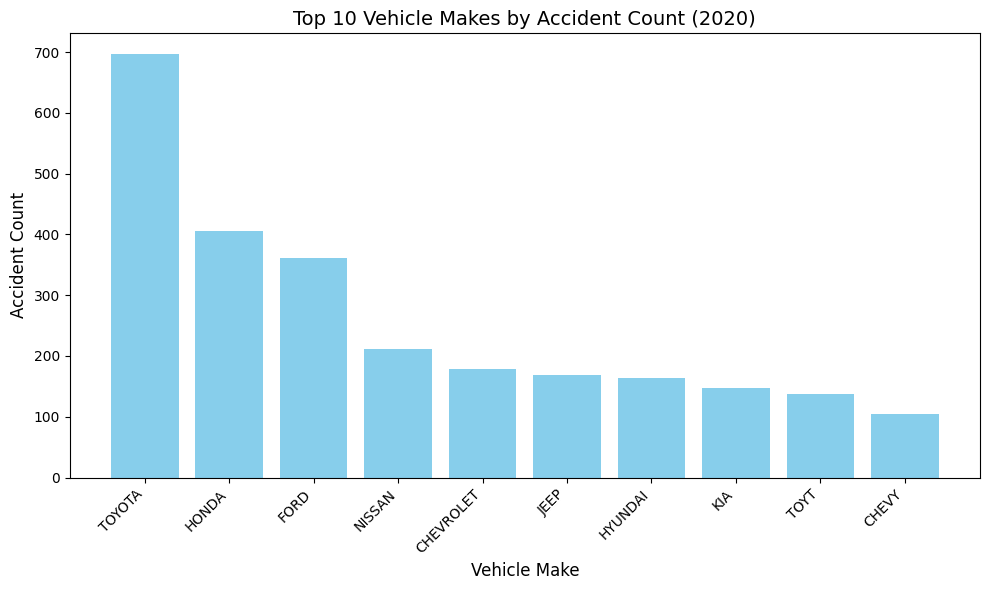

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Fetch data from Gold Table 1
fetch_gold_table_1_query = f"SELECT vehicle_year, vehicle_make, accident_count FROM {gold_table_1}"
gold_data = session.execute(fetch_gold_table_1_query)

# Convert data into a Pandas DataFrame
data = []
for row in gold_data:
    data.append({'vehicle_year': row.vehicle_year, 'vehicle_make': row.vehicle_make, 'accident_count': row.accident_count})

df = pd.DataFrame(data)

# Filter data for a specific year (e.g., "2020")
specific_year = "2020"
filtered_df = df[df['vehicle_year'] == specific_year]

# Get top 10 vehicle makes by accident count
top_10_makes = filtered_df.nlargest(10, 'accident_count')

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_10_makes['vehicle_make'], top_10_makes['accident_count'], color='skyblue')
plt.xlabel('Vehicle Make', fontsize=12)
plt.ylabel('Accident Count', fontsize=12)
plt.title(f'Top 10 Vehicle Makes by Accident Count ({specific_year})', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


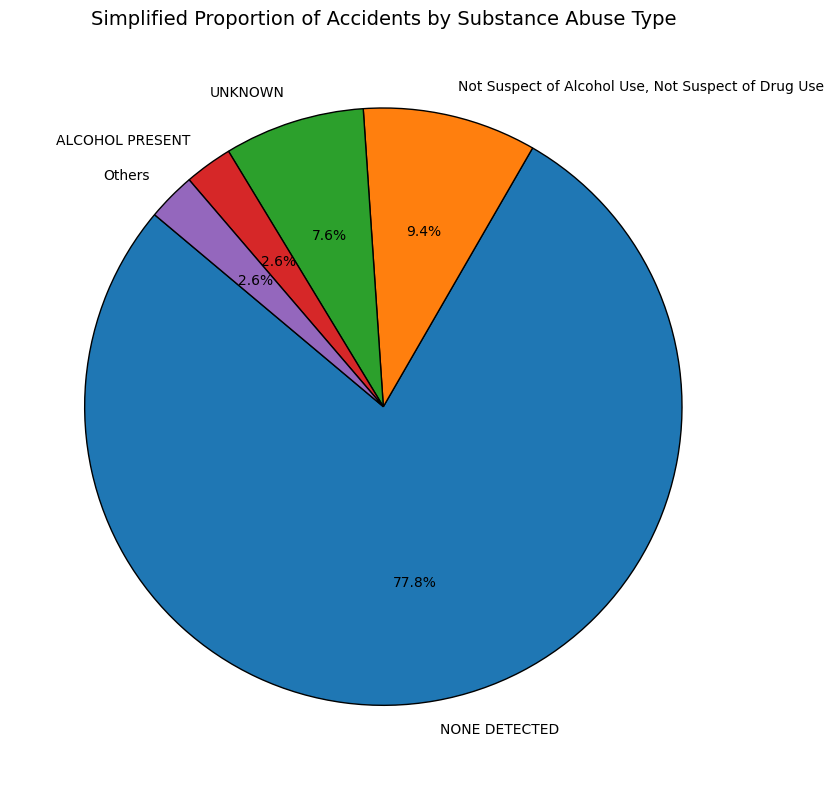

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Group smaller categories into "Others"
threshold = 0.02  # Categories with <2% will be grouped as "Others"
total_count = sum(counts)
data = [(substances[i], counts[i] / total_count) for i in range(len(substances))]
sorted_data = sorted(data, key=lambda x: x[1], reverse=True)

# Separate major categories and "Others"
major_categories = [(label, value) for label, value in sorted_data if value >= threshold]
others = sum(value for label, value in sorted_data if value < threshold)

# Add "Others" to the list
if others > 0:
    major_categories.append(("Others", others))

# Extract labels and sizes
labels, sizes = zip(*major_categories)

# Plot simplified pie chart
plt.figure(figsize=(10, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 10},
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Simplified Proportion of Accidents by Substance Abuse Type', fontsize=14)
plt.tight_layout()
plt.show()


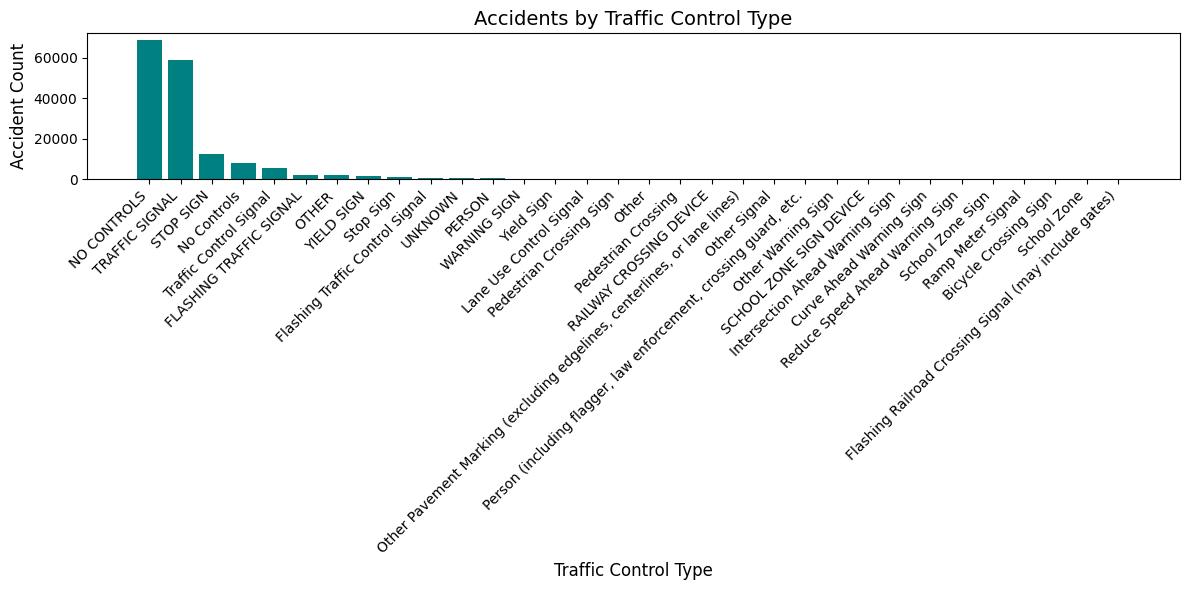

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Fetch data from Gold Table 3
fetch_gold_table_3_query = f"SELECT traffic_control, accident_count FROM {gold_table_3}"
gold_data = session.execute(fetch_gold_table_3_query)

# Convert data into a Pandas DataFrame
data = []
for row in gold_data:
    data.append({'traffic_control': row.traffic_control, 'accident_count': row.accident_count})

df = pd.DataFrame(data)

# Sort data by accident count in descending order for better visualization
df_sorted = df.sort_values(by='accident_count', ascending=False)

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(df_sorted['traffic_control'], df_sorted['accident_count'], color='teal')
plt.xlabel('Traffic Control Type', fontsize=12)
plt.ylabel('Accident Count', fontsize=12)
plt.title('Accidents by Traffic Control Type', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
